We first set up the environment.
First use momentum as the example did.
We get the `max excess_return ` Inline code which is `0.059646077829002` from the `TsPerformance` function.

In [ ]:
# Setting up environment
import datetime as dtm
from sigtech.framework import base_imports as sig

if not sig.config.is_initialised():
    sig.init(log_level='ERROR', env_date=dtm.datetime(2020, 6, 1, 11, 0))
    sig.config.set(sig.config.HISTORY_SCHEDULE_BUILD_FROM_DATA, True)

%matplotlib inline

In [2]:
from sigtech.framework.default_strategy_objects.rolling_futures import ho_comdty_f_0

ho_rf_usd_strat = sig.obj.get(ho_comdty_f_0().name)
ho_rf_usd_strat

USD HO COMDTY LONG F_0 RF STRATEGY <class 'sigtech.framework.strategies.rolling_future_strategy.RollingFutureStrategy'>[139714465181072]

In [3]:
import numpy as np
import pandas as pd
import sigtech.framework.signal.library as lib


def construct_momentum_strategy(underlying_obj_name: str, window_length: int):
    ''' Constructs a SMA-based momentum strategy with a given window length. '''

    # Get return
    signal_ts = sig.obj.get(underlying_obj_name).history().diff(window_length)

    # Create df with column name equal to underlying object name
    signal_ts = pd.DataFrame({underlying_obj_name: signal_ts})

    # Get sign of returns
    signal_ts = np.sign(signal_ts).dropna()

    # Create signal object, can be passed around between researchers
    signal_obj = lib.from_ts(signal_ts)

    return sig.SignalStrategy(
        start_date=dtm.date(2010, 1, 4),
        currency='USD',
        signal_name=signal_obj.name,
        rebalance_frequency='EOM',
        allocation_function=lib.allocation.identity,
        leverage=1,
    )

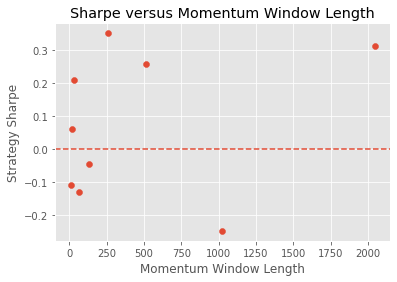

In [4]:
from sigtech.framework.analytics.performance.metrics import sharpe_ratio
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Generate window lengths as powers of 2
x = [2**i for i in range(3, 12)]

# Generate resulting Sharpe ratios
y = [sharpe_ratio(
    construct_momentum_strategy(ho_rf_usd_strat.name, w).history())
    for w in x]

# Plot results and annotate chart
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_title('Sharpe versus Momentum Window Length')
ax.set_xlabel('Momentum Window Length')
ax.set_ylabel('Strategy Sharpe')
ax.axhline(y=0., linestyle='--')

In [55]:
import math
from sigtech.framework.analytics.performance.performance_report import TsPerformance
excess_return=[]
for w in x:
    excess_return.append(TsPerformance(construct_momentum_strategy(ho_rf_usd_strat.name, w).history().to_frame('SMA-based momentum strategy')).excess_return()[0])
print(max(excess_return))


0.059646077829002


To compare with our own strategy, we also test the two example.
This is the mmr strategy.
We get the `max excess_return` which is `0.07395` at the biggest sharpe ratio.

In [7]:
def calculate_sharpe_mmr_strategy(
        underlying_obj_name: str,
        momentum_window_length: int,
        meanrev_window_length: int):
    """ Constructs a combined Momentum and Mean Reversion strategy on a given underlying. """

    # Identical lengths of windows will cancel out, ignore them
    if momentum_window_length == meanrev_window_length:
        return 0.

    # Get history of underlyer
    obj_history = sig.obj.get(underlying_obj_name).history()

    # Create momentum and mean reversion signals and combine them
    signal_momentum = obj_history.pct_change().rolling(
        window=momentum_window_length).mean()
    signal_meanrev = -obj_history.pct_change().rolling(window=meanrev_window_length).mean()
    signal_ts = signal_momentum + signal_meanrev

    # Create df with column name equal to underlying object name
    signal_ts = pd.DataFrame({underlying_obj_name: signal_ts})

    # Get sign of returns
    signal_ts = np.sign(signal_ts).dropna()

    # Create signal object, can be passed around between researchers
    signal_obj = lib.from_ts(signal_ts)

    strategy = sig.SignalStrategy(
        start_date=dtm.date(2010, 1, 4),
        currency='USD',
        signal_name=signal_obj.name,
        rebalance_frequency='EOM',
        allocation_function=lib.allocation.identity,
        leverage=1,
    )

    return sharpe_ratio(strategy.history())

Text(0, 0.5, 'Sharpe Ratio')

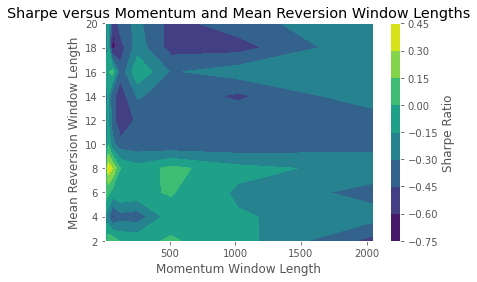

In [8]:
# Generate window lengths in specific ranges
mom_ws = [2**i for i in range(3, 12)]
mr_ws = range(2, 21, 2)

# Generate resulting Sharpe ratios in a 2D array
z = np.matrix([[calculate_sharpe_mmr_strategy(ho_rf_usd_strat.name, w1, w2)
                for w1 in mom_ws] for w2 in mr_ws])

# Plot results and annotate chart
fig, ax = plt.subplots()
plot = ax.contourf(mom_ws, mr_ws, z)
ax.set_title('Sharpe versus Momentum and Mean Reversion Window Lengths')
ax.set_xlabel('Momentum Window Length')
ax.set_ylabel('Mean Reversion Window Length')
cbar = fig.colorbar(plot, ax=ax)
cbar.ax.set_ylabel('Sharpe Ratio')

In [57]:
max_ind = np.unravel_index(np.argmax(z, axis=None), z.shape)
max_ind_mr=mr_ws[max_ind[0]]
max_ind_mom=mom_ws[max_ind[1]]
print(max_ind_mr,max_ind_mom)

8 32


In [16]:
def construct_mmr_strategy(
        underlying_obj_name: str,
        momentum_window_length: int,
        meanrev_window_length: int):
    """ Constructs a combined Momentum and Mean Reversion strategy on a given underlying. """

    # Identical lengths of windows will cancel out, ignore them
    if momentum_window_length == meanrev_window_length:
        return 0.

    # Get history of underlyer
    obj_history = sig.obj.get(underlying_obj_name).history()

    # Create momentum and mean reversion signals and combine them
    signal_momentum = obj_history.pct_change().rolling(
        window=momentum_window_length).mean()
    signal_meanrev = -obj_history.pct_change().rolling(window=meanrev_window_length).mean()
    signal_ts = signal_momentum + signal_meanrev

    # Create df with column name equal to underlying object name
    signal_ts = pd.DataFrame({underlying_obj_name: signal_ts})

    # Get sign of returns
    signal_ts = np.sign(signal_ts).dropna()

    # Create signal object, can be passed around between researchers
    signal_obj = lib.from_ts(signal_ts)

    return sig.SignalStrategy(
        start_date=dtm.date(2010, 1, 4),
        currency='USD',
        signal_name=signal_obj.name,
        rebalance_frequency='EOM',
        allocation_function=lib.allocation.identity,
        leverage=1,
    )

    

In [58]:
TsPerformance(construct_mmr_strategy(ho_rf_usd_strat.name, max_ind_mom, max_ind_mr).history().to_frame('mmr_strategy')).excess_return()

mmr_strategy    0.07395
Name: Annualised Excess Return, dtype: object

Here is our first strategy.
We think that the meanrev is not as significant as momentum, thus we lower the weight of `meanrev` by multiplying it by `0.9`.
And we get an excessive return of `0.115524` which is higher than `0.07395` in the example

In [70]:
def calculate_sharpe_own_1_strategy(
        underlying_obj_name: str,
        momentum_window_length: int,
        meanrev_window_length: int):
    """ Constructs a combined Momentum and Mean Reversion strategy on a given underlying. """

    # Identical lengths of windows will cancel out, ignore them
    if momentum_window_length == meanrev_window_length:
        return 0.

    # Get history of underlyer
    obj_history = sig.obj.get(underlying_obj_name).history()

    # Create momentum and mean reversion signals and combine them
    signal_momentum = obj_history.pct_change().rolling(
        window=momentum_window_length).mean()
    signal_meanrev = -obj_history.pct_change().rolling(window=meanrev_window_length).mean()
    signal_ts = signal_momentum + 0.9*signal_meanrev

    # Create df with column name equal to underlying object name
    signal_ts = pd.DataFrame({underlying_obj_name: signal_ts})

    # Get sign of returns
    signal_ts = np.sign(signal_ts).dropna()

    # Create signal object, can be passed around between researchers
    signal_obj = lib.from_ts(signal_ts)

    strategy = sig.SignalStrategy(
        start_date=dtm.date(2010, 1, 4),
        currency='USD',
        signal_name=signal_obj.name,
        rebalance_frequency='EOM',
        allocation_function=lib.allocation.identity,
        leverage=1,
    )

    return sharpe_ratio(strategy.history())

Text(0, 0.5, 'Sharpe Ratio')

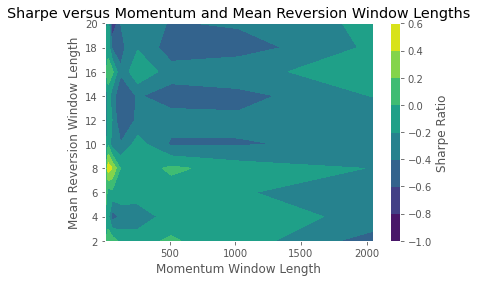

In [71]:
# Generate window lengths in specific ranges
mom_ws = [2**i for i in range(3, 12)]
mr_ws = range(2, 21, 2)

# Generate resulting Sharpe ratios in a 2D array
z = np.matrix([[calculate_sharpe_own_1_strategy(ho_rf_usd_strat.name, w1, w2)
                for w1 in mom_ws] for w2 in mr_ws])

# Plot results and annotate chart
fig, ax = plt.subplots()
plot = ax.contourf(mom_ws, mr_ws, z)
ax.set_title('Sharpe versus Momentum and Mean Reversion Window Lengths')
ax.set_xlabel('Momentum Window Length')
ax.set_ylabel('Mean Reversion Window Length')
cbar = fig.colorbar(plot, ax=ax)
cbar.ax.set_ylabel('Sharpe Ratio')

In [72]:
max_ind = np.unravel_index(np.argmax(z, axis=None), z.shape)
max_ind_mr=mr_ws[max_ind[0]]
max_ind_mom=mom_ws[max_ind[1]]
print(max_ind_mr,max_ind_mom)

8 32


In [73]:
def construct_own_1_strategy(
        underlying_obj_name: str,
        momentum_window_length: int,
        meanrev_window_length: int):
    """ Constructs a combined Momentum and Mean Reversion strategy on a given underlying. """

    # Identical lengths of windows will cancel out, ignore them
    if momentum_window_length == meanrev_window_length:
        return 0.

    # Get history of underlyer
    obj_history = sig.obj.get(underlying_obj_name).history()

    # Create momentum and mean reversion signals and combine them
    signal_momentum = obj_history.pct_change().rolling(
        window=momentum_window_length).mean()
    signal_meanrev = -obj_history.pct_change().rolling(window=meanrev_window_length).mean()
    signal_ts = signal_momentum + 0.9*signal_meanrev

    # Create df with column name equal to underlying object name
    signal_ts = pd.DataFrame({underlying_obj_name: signal_ts})

    # Get sign of returns
    signal_ts = np.sign(signal_ts).dropna()

    # Create signal object, can be passed around between researchers
    signal_obj = lib.from_ts(signal_ts)

    return sig.SignalStrategy(
        start_date=dtm.date(2010, 1, 4),
        currency='USD',
        signal_name=signal_obj.name,
        rebalance_frequency='EOM',
        allocation_function=lib.allocation.identity,
        leverage=1,
    )

In [74]:
TsPerformance(construct_own_1_strategy(ho_rf_usd_strat.name, max_ind_mom, max_ind_mr).history().to_frame('own_strategy')).excess_return()

own_strategy    0.115524
Name: Annualised Excess Return, dtype: object

Here is our second strategy.
We think that 4 pairs of difference will improve the model.
However upon execution, we cannot get a result maybe because there are too many calculation and need too much time to compute. 
 

In [64]:
def construct_own_strategy(
        underlying_obj_name: str,
        momentum_window_length_1: int,
        momentum_window_length_2: int,
        meanrev_window_length_1: int,
        meanrev_window_length_2: int):
    """ Constructs a combined Momentum and Mean Reversion strategy on a given underlying. """

    # Identical lengths of windows will cancel out, ignore them
    if ((momentum_window_length_1 == momentum_window_length_2) or 
        (momentum_window_length_1 == meanrev_window_length_1) or 
        (momentum_window_length_1 == meanrev_window_length_2) or 
        (momentum_window_length_2 == meanrev_window_length_1) or 
        (momentum_window_length_2 == meanrev_window_length_2) or 
        (meanrev_window_length_1 == meanrev_window_length_2)):
        return 0.

    # Get history of underlyer
    obj_history = sig.obj.get(underlying_obj_name).history()

    # Create momentum and mean reversion signals and combine them
    signal_momentum_1 = obj_history.pct_change().rolling(
        window=momentum_window_length_1).mean()
    signal_momentum_2 = obj_history.pct_change().rolling(
        window=momentum_window_length_2).mean()
    signal_meanrev_1 = -obj_history.pct_change().rolling(window=meanrev_window_length_1).mean()
    signal_meanrev_2 = -obj_history.pct_change().rolling(window=meanrev_window_length_2).mean()
    signal_ts = signal_momentum_1 + signal_momentum_2 + signal_meanrev_1 + signal_meanrev_2

    # Create df with column name equal to underlying object name
    signal_ts = pd.DataFrame({underlying_obj_name: signal_ts})

    # Get sign of returns
    signal_ts = np.sign(signal_ts).dropna()

    # Create signal object, can be passed around between researchers
    signal_obj = lib.from_ts(signal_ts)

    return sig.SignalStrategy(
        start_date=dtm.date(2010, 1, 4),
        currency='USD',
        signal_name=signal_obj.name,
        rebalance_frequency='EOM',
        allocation_function=lib.allocation.identity,
        leverage=1,
    )

In [65]:
def calculate_sharpe_own_strategy(
        underlying_obj_name: str,
        momentum_window_length_1: int,
        momentum_window_length_2: int,
        meanrev_window_length_1: int,
        meanrev_window_length_2: int):
    """ Constructs a combined Momentum and Mean Reversion strategy on a given underlying. """

    # Identical lengths of windows will cancel out, ignore them
    if ((momentum_window_length_1 == momentum_window_length_2) or 
        (momentum_window_length_1 == meanrev_window_length_1) or 
        (momentum_window_length_1 == meanrev_window_length_2) or 
        (momentum_window_length_2 == meanrev_window_length_1) or 
        (momentum_window_length_2 == meanrev_window_length_2) or 
        (meanrev_window_length_1 == meanrev_window_length_2)):
        return 0.

    # Get history of underlyer
    obj_history = sig.obj.get(underlying_obj_name).history()

    # Create momentum and mean reversion signals and combine them
    signal_momentum_1 = obj_history.pct_change().rolling(
        window=momentum_window_length_1).mean()
    signal_momentum_2 = obj_history.pct_change().rolling(
        window=momentum_window_length_2).mean()
    signal_meanrev_1 = -obj_history.pct_change().rolling(window=meanrev_window_length_1).mean()
    signal_meanrev_2 = -obj_history.pct_change().rolling(window=meanrev_window_length_2).mean()
    signal_ts = signal_momentum_1 + signal_momentum_2 + signal_meanrev_1 + signal_meanrev_2

    # Create df with column name equal to underlying object name
    signal_ts = pd.DataFrame({underlying_obj_name: signal_ts})

    # Get sign of returns
    signal_ts = np.sign(signal_ts).dropna()

    # Create signal object, can be passed around between researchers
    signal_obj = lib.from_ts(signal_ts)

    
    strategy = sig.SignalStrategy(
        start_date=dtm.date(2010, 1, 4),
        currency='USD',
        signal_name=signal_obj.name,
        rebalance_frequency='EOM',
        allocation_function=lib.allocation.identity,
        leverage=1,
    )

    return sharpe_ratio(strategy.history())

In [ ]:
# Generate window lengths in specific ranges
mom_ws_1 = [2**i for i in range(3, 4)]
mr_ws_1 = range(2, 21, 10)
mom_ws_2 = [2**i for i in range(3, 4)]
mr_ws_2 = range(2, 21, 10)

# Generate resulting Sharpe ratios in a 2D array
z = np.matrix([[[[calculate_sharpe_own_strategy(ho_rf_usd_strat.name, w1, w2,w3,w4)
                for w1 in mom_ws_1] for w2 in mom_ws_2]for w3 in mr_ws_1] for w4 in mr_ws_2])
max_ind = np.unravel_index(np.argmax(z, axis=None), z.shape)
print(max_ind)
max_ind_mr_1=mr_ws_1[max_ind[0]]
max_ind_mr_2=mr_ws_1[max_ind[1]]
max_ind_mom_1=mom_ws_2[max_ind[2]]
max_ind_mom_2=mom_ws_2[max_ind[3]]
TsPerformance(construct_mmr_strategy(ho_rf_usd_strat.name, max_ind_mom_1,max_ind_mom_2,max_ind_mr_1, max_ind_mr_2).history().to_frame('own_strategy')).excess_return()